# Rebuilding CNN Model From Scratch
## To familarize with TensorFlow, build a separate model
#### Suggested Tasks
- Build a CNN model classifying the diagnostic_suplerclass column in the original dataset
- Get familiar with data before feeding new data into pre-existing models
- Examine unique values, categories, and data types
- train classification on one dataset and test on another dataset

In [21]:
import tensorflow as tf # Models ran in venv python 3.9.16 with GPU computing support
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import ast
import ecg_plot
print(tf.config.list_physical_devices()) # Verify you have a GPU available. Not required
print(tf.test.is_built_with_cuda())
print(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
False
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
False


In [33]:
# preview data
df = pd.read_csv('../data/ptbxl_database.csv')
#print(df.head())
df

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21794,21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,...,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr
21795,21834,20703.0,300.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr
21796,21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr
21797,21836,8873.0,64.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-09 18:21:49,...,True,NaN,NaN,NaN,NaN,SVES,NaN,8,records100/21000/21836_lr,records500/21000/21836_hr


In [26]:
sr=100

In [52]:
with tf.device('/CPU:0'):
    ### Loading raw data into mutable Datframes
    ptb = pd.read_csv('../data/ptbxl_database.csv')
    def load_raw_data(df, sampling_rate, path):
        if(sampling_rate == 100):
            data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
        else:
            data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
        data = np.array([signal for signal, meta in data])
        return data
    
    # load and convert annotation data
    Y = pd.read_csv('../data/ptbxl_database.csv', index_col='ecg_id')
    Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

    # Load raw signal data
    X = load_raw_data(Y, sr, '../data/')

    # Load scp_statements.csv for diagnostic aggregation
    agg_df = pd.read_csv('../data/scp_statements.csv', index_col=0)
    agg_df = agg_df[agg_df.diagnostic == 1]

    def aggregate_diagnostic(y_dic):
        tmp = []
        for key in y_dic.keys():
            if key in agg_df.index:
                tmp.append(agg_df.loc[key].diagnostic_class)
        return list(set(tmp))


    # Apply diagnostic superclass
    Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [53]:
# Display Y
Y

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,[NORM]
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,[NORM]
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,[NORM]
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,[NORM]
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,[NORM]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr,[STTC]
21834,20703.0,300.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr,[NORM]
21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr,[STTC]


In [54]:
# Raw ECG signal data
X

array([[[-1.190e-01, -5.500e-02,  6.400e-02, ..., -2.600e-02,
         -3.900e-02, -7.900e-02],
        [-1.160e-01, -5.100e-02,  6.500e-02, ..., -3.100e-02,
         -3.400e-02, -7.400e-02],
        [-1.200e-01, -4.400e-02,  7.600e-02, ..., -2.800e-02,
         -2.900e-02, -6.900e-02],
        ...,
        [ 6.900e-02,  0.000e+00, -6.900e-02, ...,  2.400e-02,
         -4.100e-02, -5.800e-02],
        [ 8.600e-02,  4.000e-03, -8.100e-02, ...,  2.420e-01,
         -4.600e-02, -9.800e-02],
        [ 2.200e-02, -3.100e-02, -5.400e-02, ...,  1.430e-01,
         -3.500e-02, -1.200e-01]],

       [[ 4.000e-03,  1.380e-01,  1.340e-01, ...,  1.920e-01,
          8.300e-02,  8.800e-02],
        [-2.000e-02,  1.160e-01,  1.360e-01, ...,  1.560e-01,
          5.700e-02,  6.300e-02],
        [-5.300e-02,  9.200e-02,  1.450e-01, ...,  1.070e-01,
          1.300e-02,  2.200e-02],
        ...,
        [ 1.210e-01,  3.980e-01,  2.770e-01, ..., -1.065e+00,
         -4.920e-01, -1.560e-01],
        [-3.

In [86]:
# examples of diagnostic_superclass values
list(Y.diagnostic_superclass)

[['NORM'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['MI'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 [],
 [],
 ['NORM'],
 [],
 ['NORM'],
 ['STTC'],
 [],
 ['NORM'],
 ['NORM'],
 ['STTC'],
 ['NORM'],
 ['STTC'],
 ['NORM'],
 ['HYP'],
 ['NORM'],
 ['CD'],
 ['NORM'],
 [],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['MI', 'STTC'],
 ['NORM'],
 ['CD'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['CD', 'HYP'],
 ['NORM'],
 ['NORM'],
 ['STTC'],
 ['CD'],
 ['CD', 'MI'],
 ['NORM'],
 ['CD'],
 ['NORM'],
 ['STTC'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['MI'],
 ['NORM'],
 ['CD'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['CD', 'MI'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['CD', 'STTC'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['NORM'

In [55]:
# verifying data, etc.
# Y: samples, columns
print("Y shape:", Y.shape)
# X: samples, hz, leads
print("X shape:", X.shape)

Y shape: (21799, 28)
X shape: (21799, 1000, 12)


### Quality Filter

In [56]:
# removing samples not validated by humans
X_validated = X[Y['validated_by_human'] == True]
Y_validated = Y[Y['validated_by_human'] == True]
print(X_validated.shape)
print(Y_validated.shape)
# removing non-human-validated samples removes 5743 samples

(16056, 1000, 12)
(16056, 28)


## Distribution of diagnostic_superclass

[list([]) list(['CD']) list(['CD', 'HYP']) list(['CD', 'HYP', 'MI'])
 list(['CD', 'HYP', 'MI', 'NORM']) list(['CD', 'HYP', 'MI', 'STTC'])
 list(['CD', 'HYP', 'NORM']) list(['CD', 'HYP', 'STTC'])
 list(['CD', 'MI']) list(['CD', 'MI', 'STTC']) list(['CD', 'NORM'])
 list(['CD', 'STTC']) list(['CD', 'STTC', 'NORM']) list(['HYP'])
 list(['HYP', 'MI']) list(['HYP', 'MI', 'STTC']) list(['HYP', 'NORM'])
 list(['HYP', 'STTC']) list(['MI']) list(['MI', 'STTC']) list(['NORM'])
 list(['STTC']) list(['STTC', 'NORM'])]
[ 411 1708  300  117    1  156    2  211 1297  223  407  471    5  535
  183  361    2  781 2532  599 9069 2400   28]
['', 'CD', 'CD, HYP', 'CD, HYP, MI', 'CD, HYP, MI, NORM', 'CD, HYP, MI, STTC', 'CD, HYP, NORM', 'CD, HYP, STTC', 'CD, MI', 'CD, MI, STTC', 'CD, NORM', 'CD, STTC', 'CD, STTC, NORM', 'HYP', 'HYP, MI', 'HYP, MI, STTC', 'HYP, NORM', 'HYP, STTC', 'MI', 'MI, STTC', 'NORM', 'STTC', 'STTC, NORM']


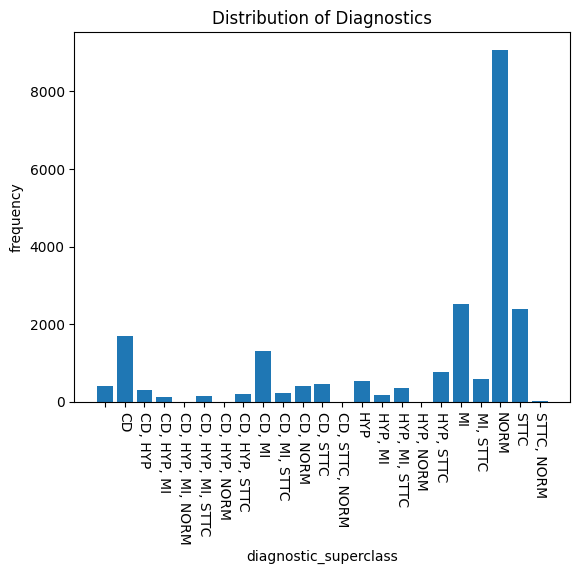

In [118]:
# values for the bar chart
uniques, counts = np.unique(pd.DataFrame(Y.diagnostic_superclass), return_counts=True)
print(uniques)
print(counts)
# implementing an int array because I keep getting a TypeError: the dtypes of parameters x (object) and width (float64) are incompatible
for_barChart = []
for i in range(len(uniques)):
    for_barChart.append(i)
# reformatting uniques to strings
for_xTicks = []
for unique in uniques:
    for_xTicks.append(', '.join(unique))
print(for_xTicks)
# barchart
plt.bar(for_barChart, counts)
plt.xticks(for_barChart, labels = for_xTicks, rotation = 270)
plt.xlabel("diagnostic_superclass")
plt.ylabel("frequency")
plt.title("Distribution of Diagnostics")
plt.show()

['Monday', 'Tuesday', 'Wednesday']


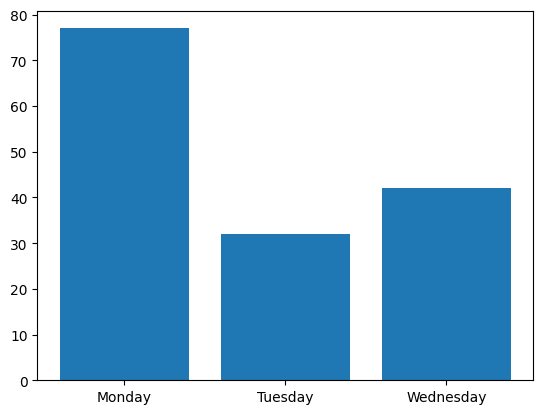

In [116]:
# Bar Chart Test
import pylab as plt

DayOfWeekOfCall = [1,2,3]
DispatchesOnThisWeekday = [77, 32, 42]

LABELS = ["Monday", "Tuesday", "Wednesday"]
print(LABELS)
plt.bar(DayOfWeekOfCall, DispatchesOnThisWeekday, align='center')
plt.xticks(DayOfWeekOfCall, LABELS)
plt.show()